In [46]:
import numpy as np
import pandas as pd
import pegasus as pg
import json
import os
import pegasusio
from pegasusio import UnimodalData, MultimodalData
import matplotlib.pyplot as plt 
import scipy.sparse
import matplotlib.patches as mpatches
import itertools
import random
import matplotlib.cm
import glob
from collections import Counter, OrderedDict
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
from utils.lists import *
from utils.plot_utils import *
from matplotlib_venn import venn2, venn2_circles
import warnings
warnings.filterwarnings('ignore')

# DEG-related numbers

In [4]:
mast = pd.read_csv('/home/ah2428/palmer_scratch/supp_tables/RNA_MAST.csv',sep='\t')

In [5]:
mast = mast[mast.Celltype.isin(['EXN','IN','OLG','OPC','END','AST','MG'])]

In [6]:
mast = mast[np.abs(mast['PTSD MAST log2FC']) > np.log2(1.2)][mast['PTSD MAST FDR'] < 0.01]

In [7]:
len(mast.Genename.unique())

3431

In [8]:
wilcox = pd.read_csv('/home/ah2428/palmer_scratch/supp_tables/RNA_WILCOX.csv',sep='\t')

In [9]:
wilcox = wilcox[wilcox.Celltype.isin(['EXN','IN','OLG','OPC','END','AST','MG'])]

In [10]:
wilcox = wilcox[np.abs(wilcox['PTSD Wilcox log2FC']) > np.log2(1.2)][wilcox['PTSD Wilcox FDR'] < 0.01]

In [11]:
len(wilcox.Genename.unique())

2989

In [14]:
deg = pd.read_csv('/home/ah2428/palmer_scratch/supp_tables/txt/PTSD_DEG_MAST_and_Wilcox.txt',sep='\t')

In [16]:
deg = deg[deg.Celltype.isin(['EXN','IN','OLG','OPC','END','AST','MG'])]

In [18]:
len(deg.Genename.unique())

1184

# Fig. 2a MAST and Wilcox Overlap DEG counts

In [22]:
deg = pd.read_csv('/home/ah2428/ShareZhangLab/PTSD/RNA/DEG_results_df/snRNA/PTSD_vs_CON/MAST_WILCOX_intersect.csv',sep='\t')

In [23]:
ups, downs = [], []
for celltype in ['CUX2','RORB','FEZF2','OPRK1','LAMP5','KCNG1','VIP','SST','PVALB','OLI','OPC','END','AST','MIC','EXC','INH']:
    deg_celltype = deg[deg.Celltype==celltype]
    deg_up = deg_celltype[deg_celltype.log2FC > 0]
    deg_down = deg_celltype[deg_celltype.log2FC < 0]
    ups.append(deg_up.shape[0])
    downs.append(deg_down.shape[0])

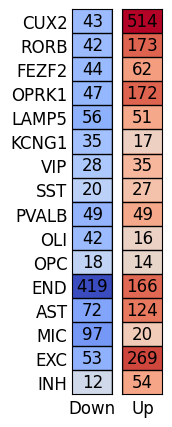

In [24]:
deg_counts_plot(ups,downs,subclasses_old+['EXC','INH'])
plt.savefig('/home/ah2428/palmer_scratch/figs/fig2/deg_counts.png',bbox_inches='tight',dpi=500)

# Fig. 2b DEG binary plot

In [33]:
deg_all = pd.read_csv('/home/ah2428/palmer_scratch/supp_tables/txt/PTSD_DEG_MAST_and_Wilcox.txt',sep='\t')
deg_all = deg[deg.Celltype.isin(['EXN','IN','OLG','OPC','END','AST','MG'])]

In [34]:
N=len(deg_all.Genename.unique())

In [35]:
degs = []
for celltype in ['EXN','IN','OLG','OPC','END','AST','MG']:
    deg = deg_all[deg_all.Celltype==celltype]
    deg_up = deg[deg['MAST log2FC'] > 0].Genename
    deg_down = deg[deg['MAST log2FC'] < 0].Genename
    deg_up_down = list(itertools.chain(*[deg_up,deg_down]))
    print(len(deg_up_down))
    degs.append(deg_up_down)

322
66
58
32
585
196
117


In [36]:
# shared DEG across EXN and IN
len(list(set(degs[0]) & set(degs[1]))) / len(list(set(list(degs[0]+degs[1]))))

0.09915014164305949

In [37]:
# shared DEG across all celltypes
len(list(set.intersection(*map(set, degs))))

0

In [38]:
all_degs = list(set(list(itertools.chain(*degs))))
len(all_degs)

1184

In [39]:
all_vals = []
for i in range(7):
    vals = []
    for deg in all_degs:
        if deg in degs[i]:
            val = 1
        else:
            val = 0
        vals.append(val)
    all_vals.append(vals)

In [40]:
arr = np.array(all_vals)

In [41]:
celltypes = ['EXN','IN','OLG','OPC','END','AST','MG']

In [42]:
arr.shape

(7, 1184)

In [43]:
df = pd.DataFrame(arr.T,columns=celltypes,index=all_degs)

In [44]:
df1 = df.sort_values(by=celltypes,ascending=False)

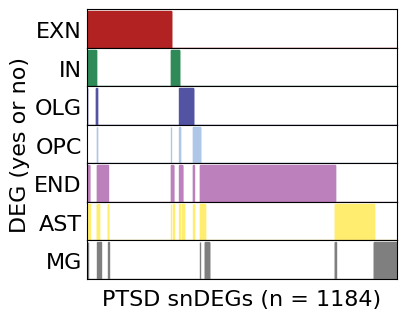

In [49]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = '16'

colors = list(celltype_colors2.values())
fig, ax = plt.subplots(7,1,sharex=True,figsize=(4,3.5),frameon=True)
ax = ax.flatten()

for ii,s in enumerate(celltypes):
    df1[[s]].plot.bar(ax=ax[ii],width=1,color=colors[ii],edgecolor=colors[ii])
    ax[ii].get_legend().remove()
    ax[ii].set_xticks([])
    ax[ii].set(yticks=np.array([0.5]),yticklabels=[s])
    ax[ii].tick_params(axis=u'both', which=u'both',length=0)
ax[3].set_ylabel('DEG (yes or no)',rotation=90)
n_deg = df1.shape[0]

plt.xlabel(f'PTSD snDEGs (n = {n_deg})')

fig.subplots_adjust(wspace=0,hspace=0)
plt.savefig('/home/ah2428/palmer_scratch/figs/fig2/deg_binary.pdf',bbox_inches='tight',dpi=300)

# Fig. 2c PTSD DEG Heatmap

In [61]:
deg = pd.read_csv('/home/ah2428/ShareZhangLab/PTSD/RNA/DEG_results_df/snRNA/PTSD_vs_CON/MAST_WILCOX_intersect.csv',sep='\t')

In [62]:
deg['abs'] = np.abs(deg.log2FC)

In [63]:
num=8
top_genes = []
for celltype in ['EXC','INH','OLI','OPC','END','AST','MIC']:
    top = dfs[dfs.celltype==celltype].sort_values(by=['FDR','abs'],ascending=[True,False])
    top = top[:num]
    top = top.sort_values('log2FC')
    print(top)
    top_genes.append(top.Genename.values)
    print(celltype,top.Genename.values)

      Unnamed: 0 Genename Celltype    log2FC  FDR celltype  mlogfdr       abs
2778        2778     ETV5      EXC -0.944080  0.0      EXC      inf  0.944080
2776        2776    BACH2      EXC -0.800933  0.0      EXC      inf  0.800933
2783        2783  PCDH11X      EXC -0.791614  0.0      EXC      inf  0.791614
2789        2789   SLC8A3      EXC -0.740142  0.0      EXC      inf  0.740142
2791        2791      UST      EXC -0.730641  0.0      EXC      inf  0.730641
1490        1490     NACA      EXC  0.841285  0.0      EXC      inf  0.841285
1472        1472      FAU      EXC  0.926347  0.0      EXC      inf  0.926347
1483        1483      JUN      EXC  1.008664  0.0      EXC      inf  1.008664
EXC ['ETV5' 'BACH2' 'PCDH11X' 'SLC8A3' 'UST' 'NACA' 'FAU' 'JUN']
      Unnamed: 0 Genename Celltype    log2FC            FDR celltype  \
2831        2831   SPRED2      INH -0.892410  2.512108e-212      INH   
2829        2829  ANKRD55      INH -0.751912  3.530369e-273      INH   
2830        2830 

In [56]:
ordered_genes = []

for x in top_genes[0]:
    ordered_genes.append(x)
    
for i in top_genes[1:]:
    for j in i:
        if j in ordered_genes:
            pass
        else:
            ordered_genes.append(j)

In [57]:
len(ordered_genes)

49

In [8]:
pd.DataFrame(ordered_genes).to_csv('/home/ah2428/ShareZhangLab/PTSD/RNA/fig2c_genes.csv',sep='\t',index=None,header=None)

In [34]:
bulk_df[bulk_df['PTSD.dlPFC.padj']<0.01]

,Geneid,Genename,PTSD.OFC.log2FoldChange,PTSD.OFC.padj,PTSD.dACC.log2FoldChange,PTSD.dACC.padj,PTSD.sgPFC.log2FoldChange,PTSD.sgPFC.padj,PTSD.dlPFC.log2FoldChange,PTSD.dlPFC.padj,Description
717,ENSG00000060138,YBX3,0.635057,0.109420,0.397637,0.392978,0.381370,0.463977,1.194728,0.000313,Y-box binding protein 3 [Source:HGNC Symbol;Ac...
1823,ENSG00000096060,FKBP5,0.488390,0.176107,0.257434,0.589784,0.378582,0.453476,0.844226,0.002427,FKBP prolyl isomerase 5 [Source:HGNC Symbol;Ac...
1889,ENSG00000099860,GADD45B,1.030106,0.036707,0.809690,0.129703,0.991818,0.226302,1.238995,0.001507,growth arrest and DNA damage inducible beta [S...
6190,ENSG00000136235,GPNMB,0.480436,0.084589,0.315436,0.394927,0.429783,0.421385,0.584992,0.006960,glycoprotein nmb [Source:HGNC Symbol;Acc:HGNC:...
14242,ENSG00000221869,CEBPD,0.526711,0.159203,0.513591,0.203727,0.305650,0.545171,0.893687,0.005219,CCAAT enhancer binding protein delta [Source:H...


In [58]:
fcs_all = []
for ii,gene in enumerate(ordered_genes):
    df = dfs[dfs.Genename==gene]
    fcs = []
    for celltype in ['EXC','INH','OLI','OPC','END','AST','MIC']:
        if celltype in df.celltype.values:
            celltype_fc = df[df.celltype==celltype].log2FC.values[0]
        else:
            celltype_fc = 0.0
        fcs.append(celltype_fc)
    fcs_all.append(fcs)
    
fcs_all = np.array(fcs_all)
bulk_deg = pd.read_csv('/gpfs/gibbs/pi/gerstein/jz435/ShareZhangLab/PTSD/RNA/jiawei_ptsd_degs.csv')

bulk_df = bulk_deg[bulk_deg.Genename.isin(ordered_genes)]
bulk_vals = bulk_df.set_index('Genename').reindex(ordered_genes)['PTSD.dlPFC.log2FoldChange'].values
bulk_vals = bulk_vals.reshape(len(ordered_genes),1)
df = pd.DataFrame(fcs_all,index=ordered_genes)
df2 = df.reindex(ordered_genes)
bulk_df[bulk_df['PTSD.dlPFC.padj']<0.01]

,Geneid,Genename,PTSD.OFC.log2FoldChange,PTSD.OFC.padj,PTSD.dACC.log2FoldChange,PTSD.dACC.padj,PTSD.sgPFC.log2FoldChange,PTSD.sgPFC.padj,PTSD.dlPFC.log2FoldChange,PTSD.dlPFC.padj,Description
717,ENSG00000060138,YBX3,0.635057,0.109420,0.397637,0.392978,0.381370,0.463977,1.194728,0.000313,Y-box binding protein 3 [Source:HGNC Symbol;Ac...
1823,ENSG00000096060,FKBP5,0.488390,0.176107,0.257434,0.589784,0.378582,0.453476,0.844226,0.002427,FKBP prolyl isomerase 5 [Source:HGNC Symbol;Ac...
1889,ENSG00000099860,GADD45B,1.030106,0.036707,0.809690,0.129703,0.991818,0.226302,1.238995,0.001507,growth arrest and DNA damage inducible beta [S...
6190,ENSG00000136235,GPNMB,0.480436,0.084589,0.315436,0.394927,0.429783,0.421385,0.584992,0.006960,glycoprotein nmb [Source:HGNC Symbol;Acc:HGNC:...
14242,ENSG00000221869,CEBPD,0.526711,0.159203,0.513591,0.203727,0.305650,0.545171,0.893687,0.005219,CCAAT enhancer binding protein delta [Source:H...


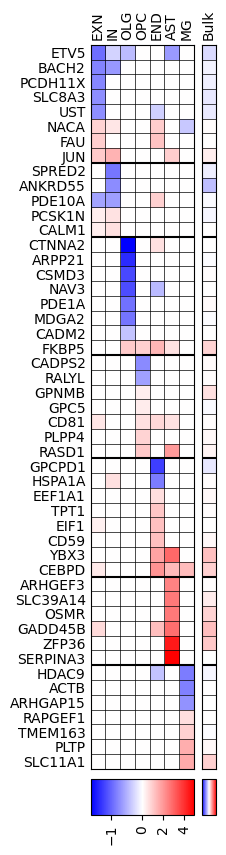

In [60]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
fig, ax = plt.subplots(1,2,figsize=(20,10))
fig.subplots_adjust(wspace=-0.955)
plt.rcParams['font.size']='10'
celltypes = ['EXN','IN','OLG','OPC','END','AST','MG']
norm = mcolors.TwoSlopeNorm(vcenter=0)

p1 = ax[0].imshow(np.array(df2),cmap='bwr',norm=norm)
ax[0].set_xticks(np.arange(len(celltypes)))
ax[0].set_xticklabels(celltypes,rotation=90)
ax[0].set_yticks(np.arange(len(ordered_genes)))
ax[0].set_yticklabels(ordered_genes)

ax[0].set_xticks(np.arange(-0.5,len(celltypes)-1),minor=True)
ax[0].set_xticklabels(celltypes,rotation=90)
ax[0].tick_params(axis=u'both', which=u'both',length=0, top=True, labeltop=True, bottom=False, labelbottom=False)

ax[0].set_xticks(np.arange(-0.5, len(celltypes)-1),minor=True)
ax[0].set_yticks(np.arange(-0.5, df2.shape[0]-1),minor=True)
ax[0].grid(which='minor', color='k', linewidth=0.5)
ax[0].grid(which='major',linewidth=0)

p2 = ax[1].imshow(bulk_vals,cmap='bwr',norm=norm)
ax[1].set_xticks(np.arange(1))
ax[1].set_xticklabels(['Bulk'],rotation=90)
ax[1].set_yticks([])
ax[1].tick_params(axis=u'both', which=u'both',length=0, top=True, labeltop=True, bottom=False, labelbottom=False)

ax[1].set_yticks(np.arange(-0.5, df2.shape[0]-1),minor=True)
ax[1].grid(which='minor', color='k', linewidth=0.5)
ax[1].grid(which='major',linewidth=0)
ax[1].tick_params(axis=u'both', which=u'both',length=0)

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
#fig.subplots_adjust(hspace=-0.83, wspace=0)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('bottom', size="5%", pad=0.1)
cb = fig.colorbar(p1,ax=ax[0],cax=cax, orientation='horizontal',ticks=[-1,0,2,4])
cb.ax.tick_params(rotation=90)

divider2 = make_axes_locatable(ax[1])
cax2 = divider2.append_axes('bottom', size="5%", pad=0.1)
cb2 = fig.colorbar(p2,ax=ax[1],cax=cax2, orientation='horizontal')
cb2.set_ticks([])
#cb2.ax.tick_params(rotation=90)

for i in [ax[0],ax[1]]:
    for l in [8,13,21,28,36,42]:
        i.axhline(y=l-0.5,color='k')

# Fig. 2d PTSD snDEGs vs MDD snDEGs Venn

In [64]:
mdd_deg = pd.read_csv('/home/ah2428/ShareZhangLab/PTSD/RNA/DEG_results_df/snRNA/MDD_vs_CON/MAST_WILCOX_intersect.csv',sep='\t')
ptsd_deg = pd.read_csv('/home/ah2428/ShareZhangLab/PTSD/RNA/DEG_results_df/snRNA/PTSD_vs_CON/MAST_WILCOX_intersect.csv',sep='\t')

In [65]:
mdd_deg = mdd_deg[mdd_deg.Celltype.isin(['EXC','INH','OLI','OPC','END','AST','MIC'])]
ptsd_deg = ptsd_deg[ptsd_deg.Celltype.isin(['EXC','INH','OLI','OPC','END','AST','MIC'])]

In [66]:
ptsd_degs = ptsd_deg.Genename.unique()
mdd_degs = mdd_deg.Genename.unique()

In [67]:
len(ptsd_degs),len(mdd_degs)

(1184, 1918)

In [71]:
inter = list(set(ptsd_degs)&set(mdd_degs))
ptsd_only = list(set(ptsd_degs)-set(inter))

In [72]:
len(inter)

682

In [73]:
len(ptsd_only)

502

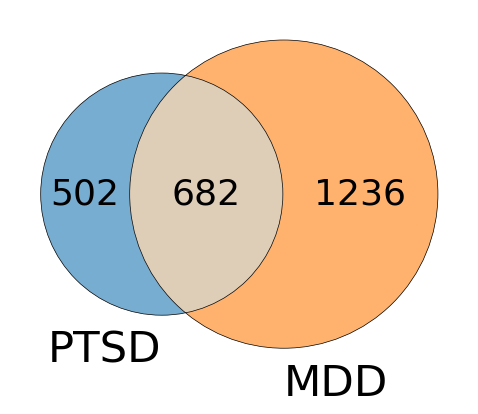

In [75]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = '26'

inter = len(list(set(ptsd_degs) & set(mdd_degs)))
venn2(subsets=(len(ptsd_degs)-inter, len(mdd_degs)-inter, inter), set_labels=('PTSD','MDD'),set_colors=('tab:blue','tab:orange'),alpha=0.6)
venn2_circles(subsets=(len(ptsd_degs)-inter, len(mdd_degs)-inter, inter),linewidth=0.5)
plt.savefig('/home/ah2428/palmer_scratch/figs/fig2/ptsd_mdd_venn.pdf',bbox_inches='tight',dpi=500)

In [76]:
682/(682+502)

0.5760135135135135

# Fig 2e. PTSD only GO

In [77]:
inter = list(set(ptsd_degs) & set(mdd_degs))

In [78]:
ptsd_only_degs = list(set(ptsd_degs)-set(inter))

In [79]:
len(ptsd_only_degs)

502

In [80]:
for x in ptsd_only_degs:
    print(x)

CHD3
MAP3K13
PDE1A
SNRNP25
SSB
ALDH1A1
VAMP5
PLPP4
POLR2J3
TMEM160
SNRPE
MKNK2
SSTR2
EFCC1
RPGRIP1L
OST4
TNFRSF25
ANKRD65
PRKCA
SLC2A13
CSF3R
NCKAP5
PTCHD4
CARF
TUBA4A
IFT172
BTG3
POLR2I
SUGP2
PKP4
TUSC2
BLOC1S6
PHC1
CXXC5
PCBD1
HS3ST3B1
EIF4H
PIAS2
CEP162
FAM184B
EFR3A
PLK2
TMEM179
EFNB2
PSMB6
PCDH8
TEF
MIEN1
MSH4
RAPGEF1
PTK2B
EEF1G
FRMD4A
SYF2
LRRC28
CXCL14
DGKZ
RCN1
PAK1
MYOM2
GPR155
PPM1L
LENG8
HSPA12A
PTCH1
ERH
CSMD2
CLIC5
FAM171A2
GNAS
SWT1
EIF4G2
GANC
NEK5
PPP1R16B
CRYBG3
DDT
TCEAL5
PLTP
CCT7
GPR26
ADAMTS18
TSGA10
PSMD4
CFI
CCT3
TMEM132A
HMGN2
LGI3
SOWAHA
RGCC
PNMA1
ARF1
SORT1
CCNL1
PNRC1
SNRK
SLC8A3
GNAI2
XBP1
TXN
HIGD1B
CDC37
BEX2
PARD6A
WASF1
LAGE3
VWC2
KBTBD6
ID3
NOP10
USP2
MRFAP1
CALN1
STAC
GTF2F1
BAG1
ADGRL4
WIPF3
CSTB
H1FX
VBP1
MYL12B
DNM2
DNAJB1
CDV3
FNIP2
C14orf132
TAF9
TMEM141
H2AFJ
ATP6V1G2
COPS7A
SLC5A6
TMEM208
PEG10
LAMP5
ENOX1
APOE
MT3
AKAP5
MAGEF1
CCND1
RHOBTB3
MOAP1
TMEM203
ARHGAP12
GPRIN3
ELK1
SERINC5
HRCT1
ADGRB3
NLRC5
C18orf32
TMEM154
ZC3H15
TMEM144
TSR2
ICAM

# 502 PTSD DEG GO

In [81]:
bp = pd.read_csv('/home/ah2428/ShareZhangLab/PTSD/RNA/GO/502_PTSD_only_GO/BP.txt',sep='\t')
cc = pd.read_csv('/home/ah2428/ShareZhangLab/PTSD/RNA/GO/502_PTSD_only_GO/CC.txt',sep='\t')
mf = pd.read_csv('/home/ah2428/ShareZhangLab/PTSD/RNA/GO/502_PTSD_only_GO/MF.txt',sep='\t')
syn = pd.read_csv('/home/ah2428/ShareZhangLab/PTSD/RNA/GO/502_PTSD_only_GO/SynGO.txt',sep='\t')
hallmark = pd.read_csv('/home/ah2428/ShareZhangLab/PTSD/RNA/GO/502_PTSD_only_GO/Hallmark.txt',sep='\t')
reactome = pd.read_csv('/home/ah2428/ShareZhangLab/PTSD/RNA/GO/502_PTSD_only_GO/Reactome.txt',sep='\t')

In [82]:
bp = bp[['Term','Adjusted P-value']]
bp['name'] = 'BP'
cc = cc[['Term','Adjusted P-value']]
cc['name'] = 'CC'
mf = mf[['Term','Adjusted P-value']]
mf['name'] = 'MF'
syn = syn[['Term','Adjusted P-value']]
syn['name'] = 'SynGO'
hallmark = hallmark[['Term','Adjusted P-value']]
hallmark['name'] = 'Hallmark'
reactome = reactome[['Term','Adjusted P-value']]
reactome['name'] = 'Reactome'

In [83]:
df = pd.concat([bp,mf,syn,reactome,hallmark])
df['-log10FDR'] = -np.log10(df['Adjusted P-value'])
df = df.sort_values('-log10FDR',ascending=False)

Text(0.5, 0, '-log10FDR')

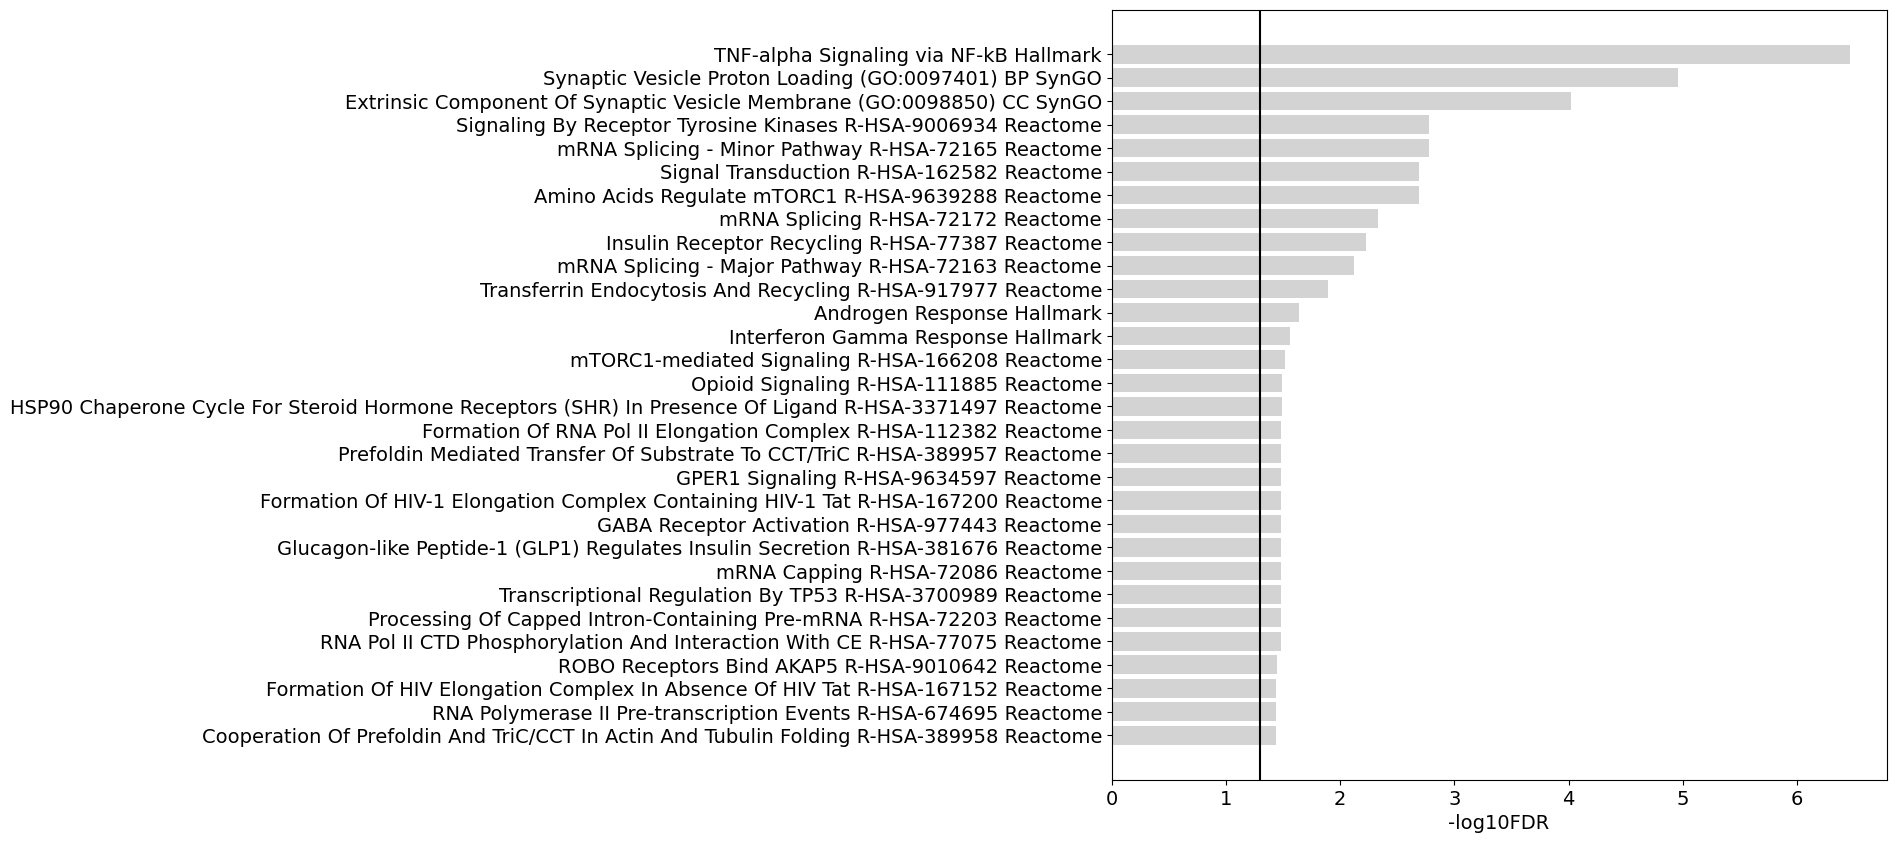

In [85]:
plt.rcParams['font.size']='14'
fig, ax = plt.subplots(figsize=(10,10))
df2 = df[:30]
terms = df2.Term+' '+df2.name
terms = terms[::-1]
plt.barh(terms,df2['-log10FDR'][::-1],color='lightgray')
plt.axvline(-np.log10(0.05),color='k')
plt.xlabel('-log10FDR')
#plt.savefig('/home/ah2428/palmer_scratch/502_go.png',bbox_inches='tight',dpi=300)

In [86]:
include = ['TNF-alpha Signaling via NF-kB',
           'Synaptic Vesicle Proton Loading (GO:0097401) BP',
           'Signaling By Receptor Tyrosine Kinases R-HSA-9006934',
           'mRNA Splicing - Minor Pathway R-HSA-72165',
           'Signal Transduction R-HSA-162582',
           'Amino Acids Regulate mTORC1 R-HSA-9639288',
           'Insulin Receptor Recycling R-HSA-77387',
           'Transferrin Endocytosis And Recycling R-HSA-917977',
           'Androgen Response', 
           'Interferon Gamma Response',
           'Opioid Signaling R-HSA-111885',
           'Glucagon-like Peptide-1 (GLP1) Regulates Insulin Secretion R-HSA-381676',
           'GABA Receptor Activation R-HSA-977443']

In [87]:
df = df[df.Term.isin(include)]

In [58]:
df

,Term,Adjusted P-value,name,-log10FDR
0,TNF-alpha Signaling via NF-kB,3.463737e-07,Hallmark,6.460455
0,Synaptic Vesicle Proton Loading (GO:0097401) BP,1.100233e-05,SynGO,4.958515
1,Signaling By Receptor Tyrosine Kinases R-HSA-9...,1.650828e-03,Reactome,2.782298
0,mRNA Splicing - Minor Pathway R-HSA-72165,1.650828e-03,Reactome,2.782298
2,Signal Transduction R-HSA-162582,2.043594e-03,Reactome,2.689605
3,Amino Acids Regulate mTORC1 R-HSA-9639288,2.043594e-03,Reactome,2.689605
5,Insulin Receptor Recycling R-HSA-77387,5.921142e-03,Reactome,2.227595
7,Transferrin Endocytosis And Recycling R-HSA-91...,1.276813e-02,Reactome,1.893873
1,Androgen Response,2.271952e-02,Hallmark,1.643601
2,Interferon Gamma Response,2.750877e-02,Hallmark,1.560529


In [88]:
terms = ['TNF-alpha Signaling',
         'Synaptic Vesicle',
         'Receptor Tyrosine Kinases',
         'mRNA Splicing',
         'Signal Transduction',
         'Amino Acids Regulate mTORC1',
         'Insulin Receptor Recycling',
         'Transferrin Endocytosis',
         'Androgen Response',
         'Inteferon Gamma Response',
         'Opioid Signaling',
         'GLP1 Regulates Insulin',
         'GABA Receptor Activation']

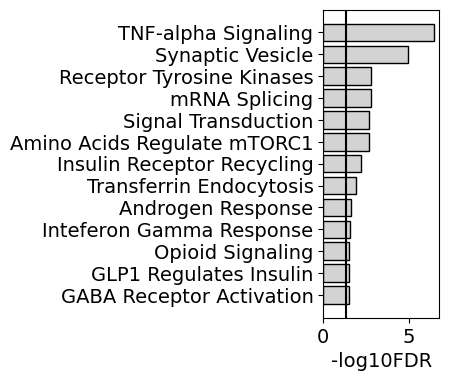

In [89]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = '14'

fig, ax = plt.subplots(figsize=(1.5,4))

ax.barh(np.arange(len(terms)), df['-log10FDR'], align='center', color='lightgray', edgecolor='black', linewidth=1)
ax.set_yticks(np.arange(df.shape[0]))
ax.set_yticklabels(terms)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('-log10FDR')
ax.axvline(-np.log10(0.05),color='k')
plt.savefig('/home/ah2428/palmer_scratch/figs/fig2/502_ptsd_GO.pdf',bbox_inches='tight',dpi=500)

# Fig. 2f EEF1A1 and HSPA1A violin

In [3]:
ptsd_mdd = pg.read_input('/gpfs/gibbs/pi/gerstein/jz435/ShareZhangLab/PTSD/RNA/data/PTSD_MDD.zarr')

/gpfs/gibbs/pi/gerstein/ah2428/conda_envs/pegasus/lib/python3.10/site-packages/pegasusio/zarr_utils.py:77: FutureWarning: The NestedDirectoryStore is deprecated and will be removed in a Zarr-Python version 3, see https://github.com/zarr-developers/zarr-python/issues/1274 for more information.
  self.store = zarr.NestedDirectoryStore(path) if os.path.isdir(path) else zarr.ZipStore(path, mode = 'r')


2024-08-30 09:27:51,871 - pegasusio.readwrite - INFO - zarr file '/gpfs/gibbs/pi/gerstein/jz435/ShareZhangLab/PTSD/RNA/data/PTSD_MDD.zarr' is loaded.
2024-08-30 09:27:51,872 - pegasusio.readwrite - INFO - Function 'read_input' finished in 159.10s.


In [7]:
ptsd_mdd.obs.subclass = ptsd_mdd.obs.subclass.cat.reorder_categories(['CUX2','RORB','FEZF2','OPRK1','LAMP5','KCNG1','VIP','SST','PVALB','OLI','OPC','END','AST','MIC'])

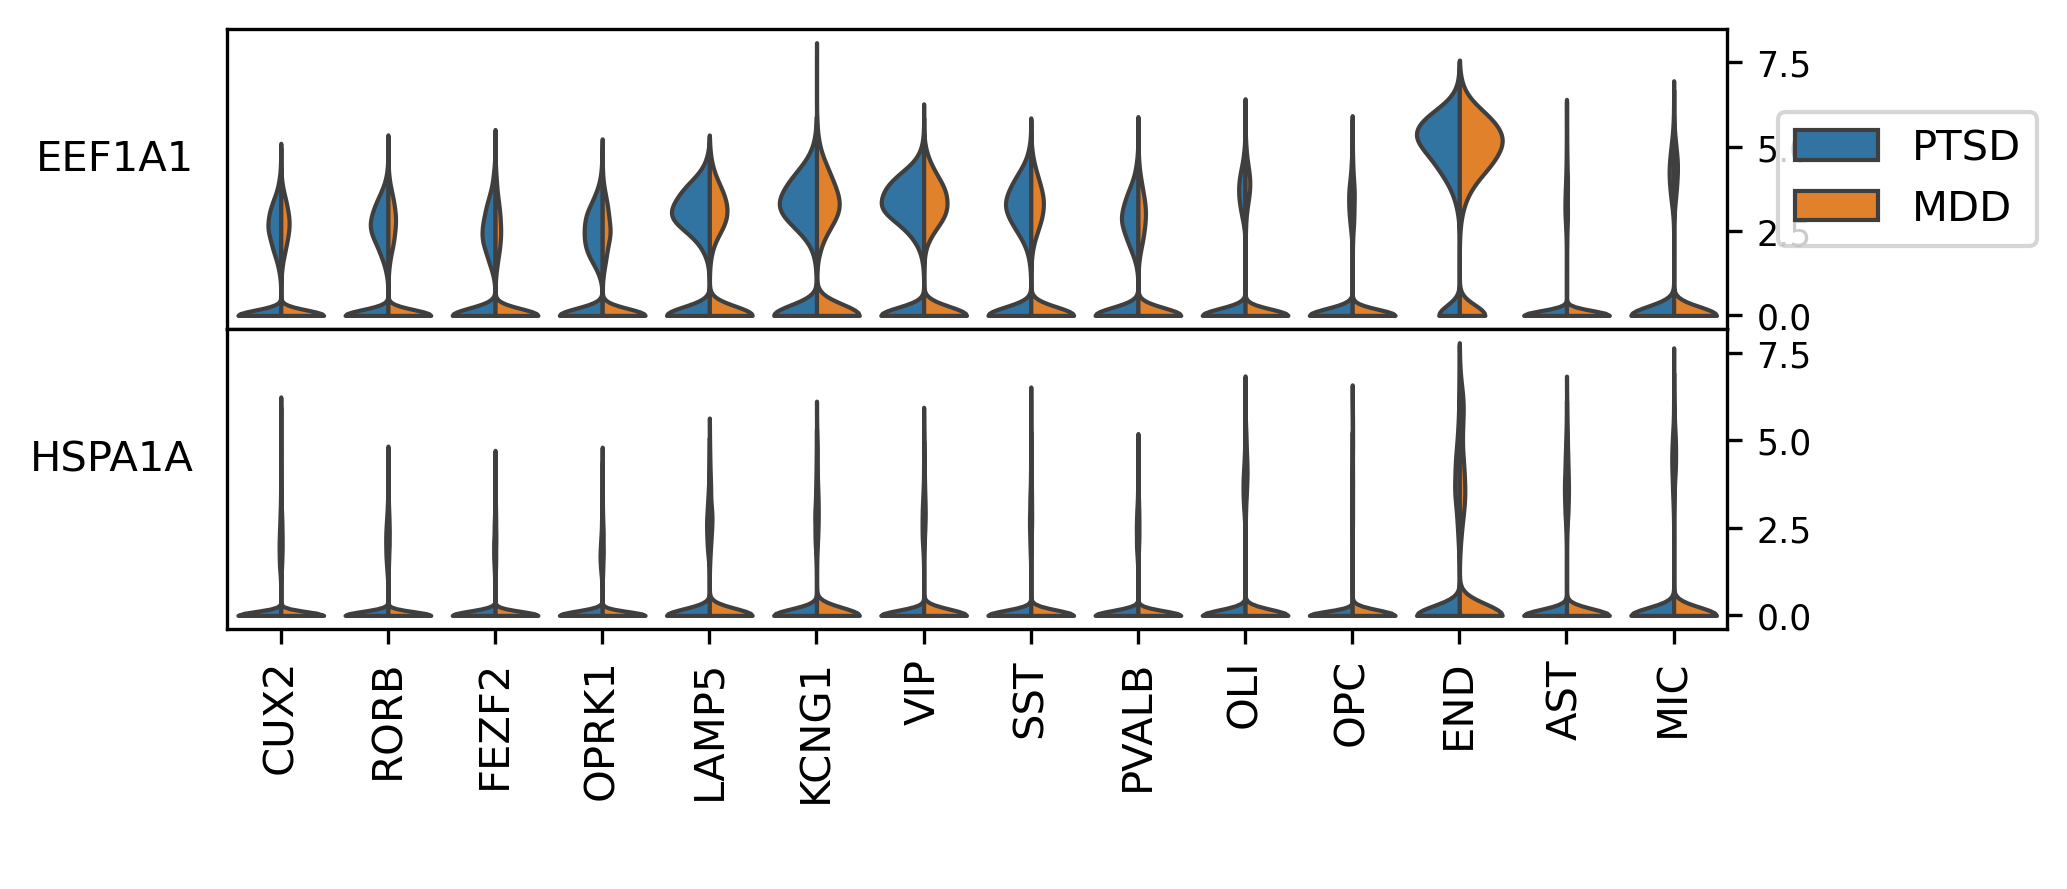

In [9]:
pg.violin(ptsd_mdd,attrs=['EEF1A1','HSPA1A'],groupby='subclass',hue='Condition',panel_size=(5,1))
plt.xlabel(' ')
plt.savefig('/home/ah2428/palmer_scratch/figs/fig2/violin.pdf',bbox_inches='tight',dpi=300)